In [50]:
import os
import cv2
import numpy as np

data_dir = r"C:\Users\miray\OneDrive\Desktop\Internship\SCT_ML_3"

def load_images(data_dir, image_size=(224, 224)):
    X = []
    y = []
    classes = ['Cat', 'Dog']
    for label, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

X, y = load_images(data_dir)
print(f"Loaded {len(X)} images.")


Loaded 1000 images.


In [51]:
import tensorflow as tf

def extract_embeddings(X):
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    X_preprocessed = preprocess_input(X)
    embeddings = base_model.predict(X_preprocessed, batch_size=32, verbose=1)
    return embeddings

X_emb = extract_embeddings(X)
print("Embeddings shape:", X_emb.shape)


32/32 [==============================] - 26s 771ms/step
Embeddings shape: (1000, 1280)


In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X_emb, y):
    X_train, X_test = X_emb[train_idx], X_emb[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train_orig, X_test_orig = X[train_idx], X[test_idx]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 800, Test samples: 200


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, random_state=42)
grid = GridSearchCV(svm, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [56]:
from sklearn.metrics import classification_report, accuracy_score

best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))


Test Accuracy: 0.9750
              precision    recall  f1-score   support

         Cat       1.00      0.95      0.97       100
         Dog       0.95      1.00      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



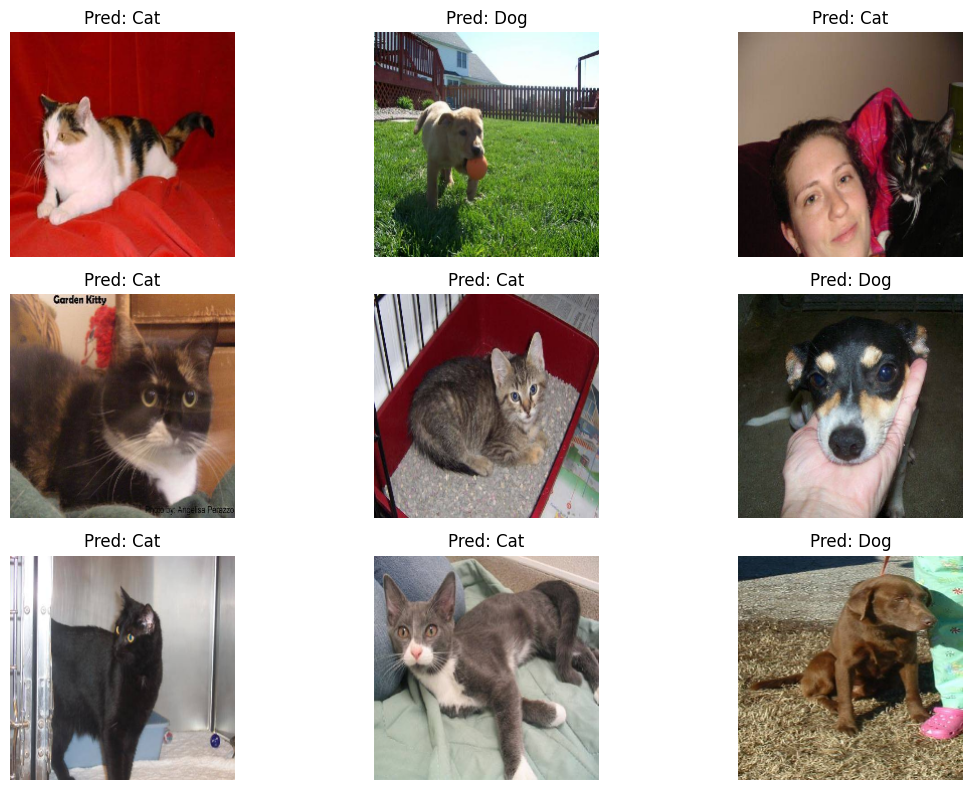

In [58]:
import matplotlib.pyplot as plt

def plot_predictions(X_orig, y_true, y_pred, indices, class_names=['Cat', 'Dog']):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_orig[idx].astype('uint8'))
        plt.title(f"Pred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import numpy as np
test_indices = np.random.choice(len(y_test), 9, replace=False)
plot_predictions(X_test_orig, y_test, y_pred, test_indices)
